# Feature Analyzation

## Principal Component Analysis (PCA)

### Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA
from typing import Tuple, Union
from factor_analyzer.rotator import Rotator

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from pandas import DataFrame, Series

### Function definitions

In [2]:
def load_data(filepath: str, sep: str = "\t") -> DataFrame:
    """
    Loads data from a specified file path.

    Args:
        filepath (str): The path to the data file.
        sep (str): The separator used in the file (e.g., '\\t' or ',').

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.

    Raises:
        FileNotFoundError: If the file cannot be found at the specified path.
    """
    print(f"Loading data from '{filepath}'...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: The file '{filepath}' was not found.")

    df = pd.read_csv(filepath, sep=sep)
    print("Data loaded successfully.")
    return df


def preprocess_features(df: DataFrame, target_col: str, id_col: str) -> Tuple[DataFrame, Series]:
    """
    Prepares the data for machine learning by separating features and target,
    one-hot encoding categoricals, and removing constant features.

    Args:
        df (DataFrame): The data input DataFrame.
        target_col (str): The name of the target variable column.
        id_col (str): The name of the unique identifier column.

    Returns:
        Tuple[DataFrame, Series]: A tuple containing:
            - X_final (DataFrame): The cleaned and processed feature set.
            - y (Series): The target variable series.
    """
    print("Preprocessing features...")
    y = df[target_col]
    X = df.drop(columns=[id_col, target_col])
    print(f"Original feature shape: {X.shape}")

    # One-hot encode categorical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if not categorical_cols.empty:
        print(f"One-hot encoding categorical columns: {categorical_cols.tolist()}")
        X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)

    # Remove constant features (zero variance)
    constant_features = [col for col in X.columns if X[col].nunique() == 1]
    if constant_features:
        print(f"Removing {len(constant_features)} constant features...")
        X_final = X.drop(columns=constant_features)
    else:
        X_final = X

    print(f"Final feature shape after preprocessing: {X_final.shape}")
    return X_final, y


def scale_features(X_df: DataFrame) -> Tuple[np.ndarray, StandardScaler]:
    """
    Standardizes features to have a mean of 0 and a standard deviation of 1.

    Args:
        X_df (DataFrame): The feature DataFrame to scale.

    Returns:
        Tuple[np.ndarray, StandardScaler]: A tuple containing:
            - X_scaled (np.ndarray): The scaled feature data.
            - scaler (StandardScaler): The fitted scaler object for future use.
    """
    print("Standardizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    print("Features standardized successfully.")
    return X_scaled, scaler


def plot_scree(X_scaled: np.ndarray, output_path: str):
    """
    Performs PCA and plots the explained variance (scree plot) to help determine
    the optimal number of components.

    Args:
        X_scaled (np.ndarray): The scaled feature data.
        output_path (str): The file path to save the plot image.
    """
    print("Generating scree plot...")
    pca = PCA()
    pca.fit(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(12, 7))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6,
            label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
             label='Cumulative explained variance')

    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.title('Scree Plot: Explained Variance by Principal Component')
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig(output_path)
    print(f"Scree plot saved to '{output_path}'")
    plt.show()


def visualize_pca_2d(X_scaled: np.ndarray, y: Series, output_path: str):
    """
    Reduces data to 2 principal components and creates a scatter plot.

    Args:
        X_scaled (np.ndarray): The scaled feature data.
        y (Series): The target variable for coloring the plot.
        output_path (str): The file path to save the plot image.
    """
    print("Generating 2D PCA visualization...")
    pca_2d = PCA(n_components=2)
    principal_components = pca_2d.fit_transform(X_scaled)

    df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    df_pca['target'] = y.reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    sns.scatterplot(x='PC1', y='PC2', hue='target', data=df_pca, palette='viridis', s=70, alpha=0.8)

    pc1_var = pca_2d.explained_variance_ratio_[0] * 100
    pc2_var = pca_2d.explained_variance_ratio_[1] * 100
    plt.title('2D PCA of the Dataset')
    plt.xlabel(f'Principal Component 1 ({pc1_var:.2f}% Variance)')
    plt.ylabel(f'Principal Component 2 ({pc2_var:.2f}% Variance)')
    plt.legend(title=y.name)
    plt.grid(True)

    plt.savefig(output_path)
    print(f"2D PCA visualization saved to '{output_path}'")
    plt.show()


def visualize_pca_with_varimax_2d(X_scaled: np.ndarray, y: pd.Series, output_path: str):
    """
    Performs PCA, applies a Varimax rotation, and creates a scatter plot
    to demonstrate the effect of rotation on the components.

    Args:
        X_scaled (np.ndarray): The scaled feature data.
        y (Series): The target variable for coloring the plot.
        output_path (str): The file path to save the plot image.
    """
    print("Generating 2D PCA visualization with Varimax rotation...")

    # 1. Perform a standard PCA to get the components
    pca_2d = PCA(n_components=2)
    # Note: We use fit_transform here to get the scores for the original plot if needed,
    # but for rotation, we primarily need the loadings from the fitted pca_2d object.
    principal_components = pca_2d.fit_transform(X_scaled)

    # 2. Get the component loadings (principal axes). The rotator works on these.
    # The shape will be (n_features, n_components)
    loadings = pca_2d.components_.T

    # 3. Apply Varimax rotation to the loadings
    rotator = Rotator(method='varimax')
    rotated_loadings = rotator.fit_transform(loadings)

    # 4. Calculate the new data point scores in the rotated system
    # This is done by projecting the original scaled data onto the new rotated axes
    X_rotated = np.dot(X_scaled, rotated_loadings)

    # 5. Create a DataFrame for plotting
    df_rotated = pd.DataFrame(data=X_rotated, columns=['Rotated Component 1', 'Rotated Component 2'])
    df_rotated['target'] = y.reset_index(drop=True)

    # 6. Plot the result
    plt.figure(figsize=(12, 9))
    sns.scatterplot(x='Rotated Component 1', y='Rotated Component 2', hue='target',
                    data=df_rotated, palette='viridis', s=70, alpha=0.8)

    plt.title('2D PCA of the Dataset After Varimax Rotation')
    plt.xlabel('Rotated Component 1')
    plt.ylabel('Rotated Component 2')
    plt.legend(title=y.name)
    plt.grid(True)
    plt.axhline(0, color='grey', lw=1, linestyle='--')
    plt.axvline(0, color='grey', lw=1, linestyle='--')

    plt.savefig(output_path)
    print(f"Varimax-rotated 2D PCA visualization saved to '{output_path}'")
    plt.show()


def transform_and_save_pca(X_scaled: np.ndarray, y: Series, df_original: DataFrame, id_col: str,
                             n_components: Union[int, float], output_path: str):
    """
    Performs PCA transformation with a specified number of components and saves
    the result to a file.

    Args:
        X_scaled (np.ndarray): The scaled feature data.
        y (Series): The target variable.
        df_original (DataFrame): The original DataFrame to retrieve identifiers.
        id_col (str): The name of the unique identifier column.
        n_components (Union[int, float]): The number of components to keep.
            If float (e.g., 0.95), it's the variance to retain.
            If int (e.g., 10), it's the exact number of components.
        output_path (str): The file path to save the transformed data CSV.
    """
    print(f"Transforming data with n_components={n_components}...")
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    num_final_components = pca.n_components_
    print(f"Data transformed into {num_final_components} components.")

    # Create the final DataFrame
    pca_cols = [f'PC_{i+1}' for i in range(num_final_components)]
    df_pca_final = pd.DataFrame(X_pca, columns=pca_cols)

    # Add back the identifier and target columns for context
    df_pca_final[id_col] = df_original[id_col].reset_index(drop=True)
    df_pca_final[y.name] = y.reset_index(drop=True)

    # Reorder columns to have identifiers first
    final_cols = [id_col, y.name] + pca_cols
    df_pca_final = df_pca_final[final_cols]

    df_pca_final.to_csv(output_path, sep="\t", index=False)
    print(f"Transformed data saved to '{output_path}'")

def extract_timestamp_from_filepath(filepath: str) -> str:
    """
    Extracts a timestamp from the file path if it exists.

    Args:
        filepath (str): The file path to extract the timestamp from.

    Returns:
        str: The extracted timestamp or an empty string if not found.
    """
    match = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', filepath)
    return match.group(0) if match else ""


def visualize_lda(X_lda: np.ndarray, y: Series, output_path: str):
    """
    Visualizes the result of LDA. For 2 classes, this will be a 1D plot (histogram).
    For 3+ classes, this will be a 2D scatter plot.

    Args:
        X_lda (np.ndarray): The data transformed by LDA.
        y (Series): The target variable for coloring the plot.
        output_path (str): The file path to save the plot image.
    """
    print("Generating LDA visualization...")
    df_lda = pd.DataFrame(data=X_lda)
    df_lda['target'] = y.reset_index(drop=True)
    n_components = X_lda.shape[1]

    plt.figure(figsize=(12, 8))
    ax = plt.gca() # Get current axes

    if n_components == 1:
        # For binary classification, LDA produces one component. A histogram/density plot is best.
        sns.histplot(data=df_lda, x=0, hue='target', multiple='layer', palette='viridis', kde=True)
        plt.title('LDA of the Dataset (1 Discriminant Component)')
        plt.xlabel('Linear Discriminant 1')
        plt.ylabel('Frequency')
    else:
        # For 3+ classes, LDA can produce up to n_classes-1 components.
        df_lda.columns = ['LD1', 'LD2'] + list(df_lda.columns[2:])
        sns.scatterplot(x='LD1', y='LD2', hue='target', data=df_lda.iloc[:, :3], palette='viridis', s=70, alpha=0.8)
        plt.title('LDA of the Dataset (2 Discriminant Components)')
        plt.xlabel('Linear Discriminant 1')
        plt.ylabel('Linear Discriminant 2')

    # Get the legend object that seaborn created and set its title
    try:
        legend = ax.get_legend()
        legend.set_title(y.name)
    except AttributeError:
        print("Could not set legend title.")
    plt.grid(True)
    plt.savefig(output_path)
    print(f"LDA visualization saved to '{output_path}'")
    plt.show()


def transform_and_save_lda(X_scaled: np.ndarray, y: Series, df_original: DataFrame, id_col: str, output_path: str):
    """
    Performs LDA transformation and saves the result to a file.

    Args:
        X_scaled (np.ndarray): The scaled feature data.
        y (Series): The target variable.
        df_original (DataFrame): The original DataFrame to retrieve identifiers.
        id_col (str): The name of the unique identifier column.
        output_path (str): The file path to save the transformed data CSV.
    """
    # Use the 'svd' solver which is recommended for a large number of features
    # and does not compute the covariance matrix, avoiding singularity issues.
    print("Fitting LDA model...")
    lda = LDA(solver='svd')
    X_lda = lda.fit_transform(X_scaled, y)

    # Get the number of components from the shape of the output array
    num_final_components = X_lda.shape[1]

    print(f"Data transformed into {num_final_components} discriminant components.")

    # Create the final DataFrame
    lda_cols = [f'LD_{i+1}' for i in range(num_final_components)]
    df_lda_final = pd.DataFrame(X_lda, columns=lda_cols)

    # Add back the identifier and target columns
    df_lda_final[id_col] = df_original[id_col].reset_index(drop=True)
    df_lda_final[y.name] = y.reset_index(drop=True)

    # Reorder columns
    final_cols = [id_col, y.name] + lda_cols
    df_lda_final = df_lda_final[final_cols]

    df_lda_final.to_csv(output_path, sep="\t", index=False)
    print(f"Transformed LDA data saved to '{output_path}'")
    return X_lda

def find_best_threshold_and_accuracy(X_lda_1d: np.ndarray, y: Series):
    """
    Finds the optimal threshold for a 1D LDA result to maximize classification accuracy.
    This version is robust to the encoding of class labels.
    """
    print("\n--- Finding Best Threshold for Classification (Corrected Method) ---")

    y_true = y.to_numpy()
    classes = np.unique(y_true)

    # Create a range of potential thresholds to test
    min_val, max_val = X_lda_1d.min(), X_lda_1d.max()
    thresholds = np.linspace(min_val, max_val, num=2000)

    best_accuracy = 0
    best_threshold = None

    for threshold in thresholds:
        # --- THE FIX ---
        # Test both possible assignments for which class is on the "left" vs "right"
        # Assignment A: low scores -> classes[0], high scores -> classes[1]
        pred_a = np.where(X_lda_1d < threshold, classes[0], classes[1])
        acc_a = accuracy_score(y_true, pred_a)

        # Assignment B: low scores -> classes[1], high scores -> classes[0]
        pred_b = np.where(X_lda_1d < threshold, classes[1], classes[0])
        acc_b = accuracy_score(y_true, pred_b)

        # The true accuracy for this threshold is the better of the two assignments
        acc = max(acc_a, acc_b)

        # Update if we found a better threshold
        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best Achievable Accuracy with this model: {best_accuracy * 100:.2f}%")
    return best_threshold, best_accuracy

def evaluate_pipeline_robustly(X, y):
    """Evaluates a full pipeline using cross-validation."""
    print("\n--- Running Robust Cross-Validation with a Pipeline ---")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lda', LDA(solver='svd')),
        ('classifier', LogisticRegression())
    ])
    cv = LeaveOneOut()
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    print(f"Cross-validation finished after {len(scores)} folds.")
    print(f"Mean Accuracy: {np.mean(scores) * 100:.2f}%")
    print(f"Standard Deviation: {np.std(scores) * 100:.2f}%")

def evaluate_pca_pipeline(X, y, n_components=5):
    """
    Evaluates a full pipeline (scaling -> PCA -> classifier) using cross-validation.
    """
    print(f"\n--- Running Robust CV with PCA ({n_components} components) ---")

    # The pipeline is the same, just with the 'lda' step replaced by 'pca'
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # Use Leave-One-Out Cross-Validation for a robust estimate
    cv = LeaveOneOut()
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Report the results
    print(f"Cross-validation finished after {len(scores)} folds.")
    print(f"Mean Accuracy: {np.mean(scores) * 100:.2f}%")
    print(f"Standard Deviation: {np.std(scores) * 100:.2f}%")


### Configuration

In [3]:
# --- Configuration ---
FILEPATH = 'agg_data/ml_features_non_medical_20250711_021809.csv'
TARGET_COLUMN = 'is.expert'
ID_COLUMN = 'Participant_unique'
OUTPUT_DIR = "pca_files"
N_COMPONENTS_FOR_TRANSFORM = 49 # Export all features # 0.95  # Retain 95% of variance

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Extract the data file timestamp for file naming
TIMESTRING = extract_timestamp_from_filepath(FILEPATH) or datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

print("Configuration set and output directory is ready.")

Configuration set and output directory is ready.


### Main Execution Logic

Loading data from 'agg_data/ml_features_non_medical_20250711_021809.csv'...
Data loaded successfully.
Preprocessing features...
Original feature shape: (50, 208)
Removing 25 constant features...
Final feature shape after preprocessing: (50, 183)
Standardizing features...
Features standardized successfully.
Generating scree plot...
Scree plot saved to 'pca_files/pca_scree_plot_ml_features_non_medical_20250711_021809.png'


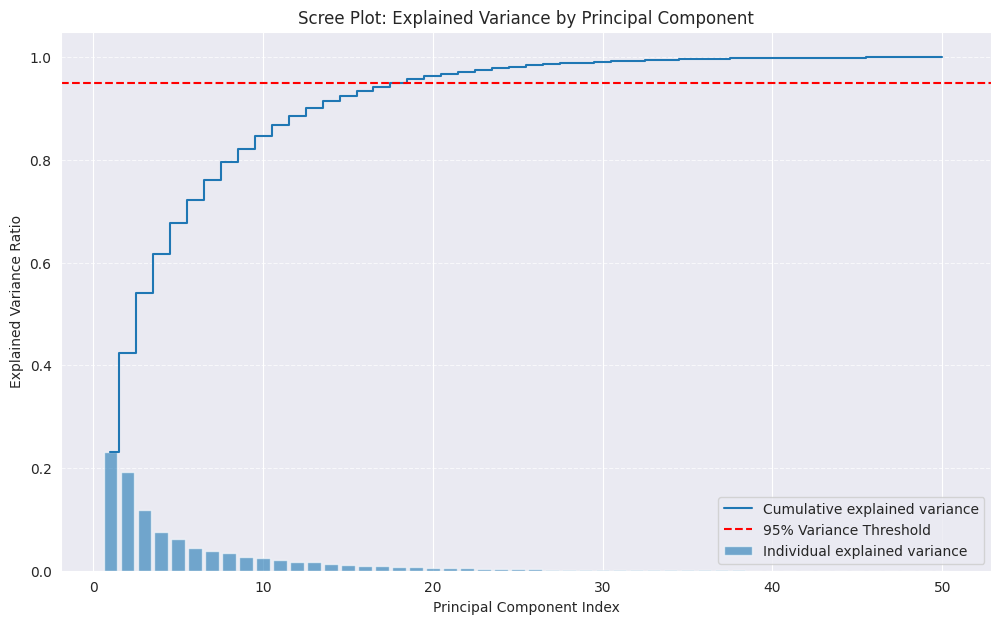

Generating 2D PCA visualization...
2D PCA visualization saved to 'pca_files/pca_2d_visualization_ml_features_non_medical_20250711_021809.png'


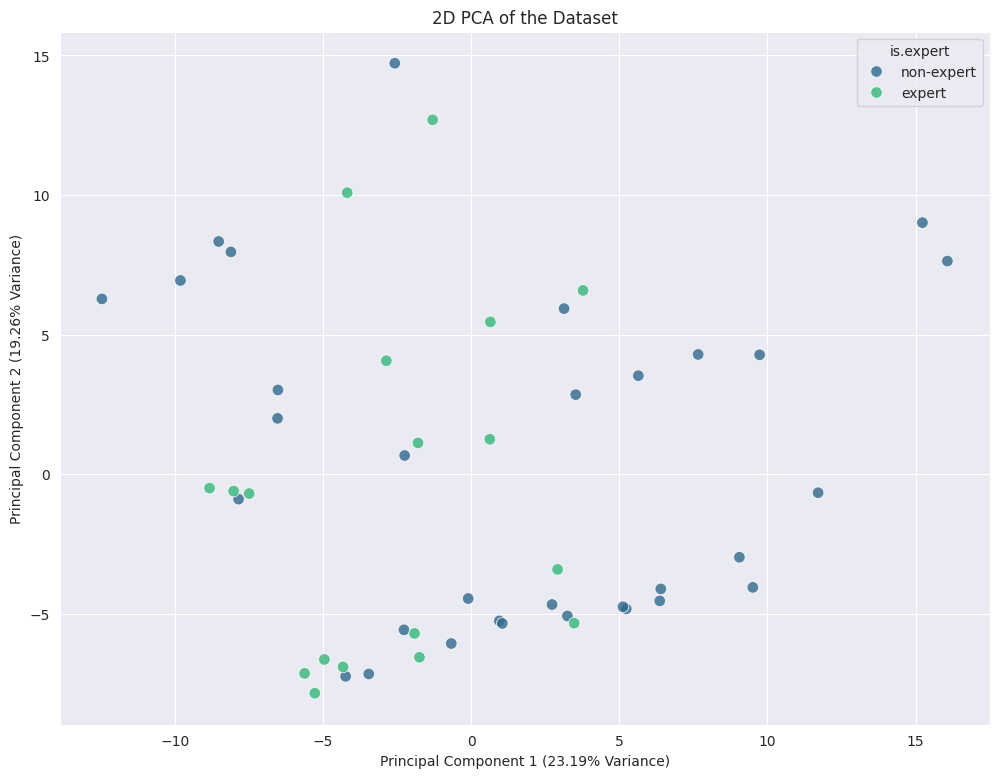


--- Performing Varimax Rotation Experiment ---
Generating 2D PCA visualization with Varimax rotation...
Varimax-rotated 2D PCA visualization saved to 'pca_files/pca_varimax_2d_visualization_ml_features_non_medical_20250711_021809.png'


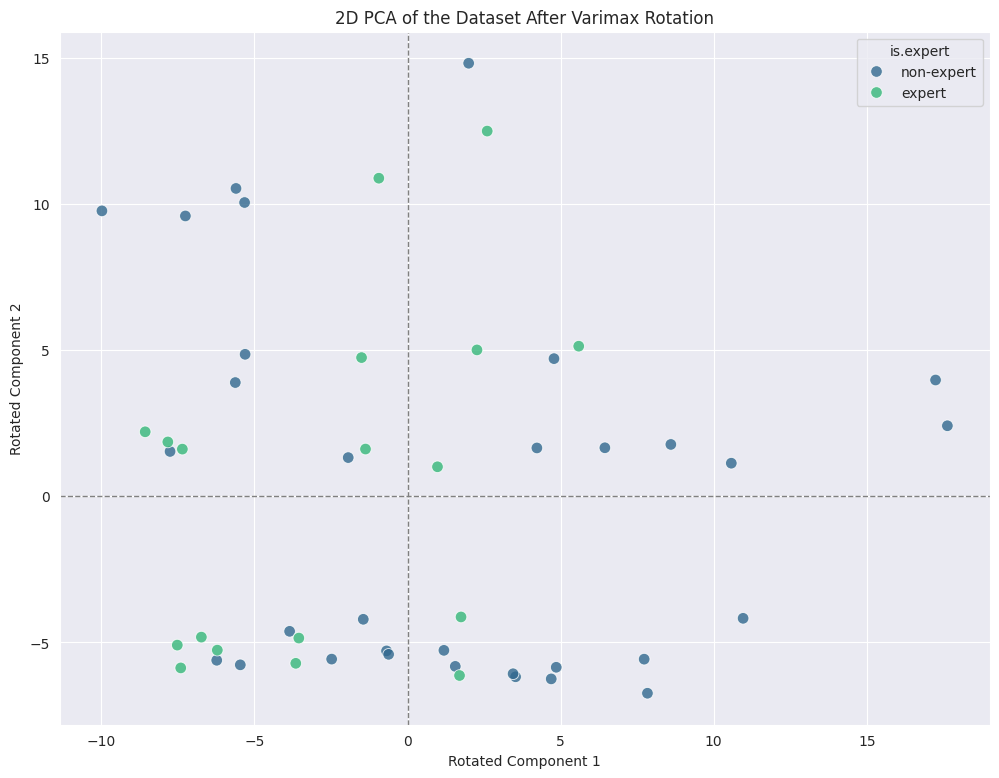

--- End of Experiment ---

Transforming data with n_components=49...
Data transformed into 49 components.
Transformed data saved to 'pca_files/pca_data_ml_features_non_medical_20250711_021809.csv'

PCA analysis complete.


In [4]:
try:
    # Extract original filename (without extension)
    original_filename = os.path.splitext(os.path.basename(FILEPATH))[0]

    # 1. Load Data
    df_raw = load_data(FILEPATH)

    # 2. Preprocess Features
    X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

    # 3. Scale Features
    X_scaled, scaler = scale_features(X_final)

    # 4. Analyze Variance and Generate Scree Plot
    scree_plot_path = os.path.join(OUTPUT_DIR, f'pca_scree_plot_{original_filename}.png')
    plot_scree(X_scaled, scree_plot_path)

    # 5. Visualize Data in 2D (Original PCA)
    viz_2d_path = os.path.join(OUTPUT_DIR, f'pca_2d_visualization_{original_filename}.png')
    visualize_pca_2d(X_scaled, y_target, viz_2d_path)

    # 5b. EXPERIMENT: Visualize with Varimax to confirm it doesn't create separability
    print("\n--- Performing Varimax Rotation Experiment ---")
    viz_varimax_path = os.path.join(OUTPUT_DIR, f'pca_varimax_2d_visualization_{original_filename}.png')
    visualize_pca_with_varimax_2d(X_scaled, y_target, viz_varimax_path)
    print("--- End of Experiment ---\n")

    # 6. Transform and Save Final Dataset
    transformed_data_path = os.path.join(OUTPUT_DIR, f'pca_data_{original_filename}.csv')
    transform_and_save_pca(X_scaled, y_target, df_raw, ID_COLUMN,
                           N_COMPONENTS_FOR_TRANSFORM, transformed_data_path)

    print("\nPCA analysis complete.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

## LDA (Linear Discriminant Analysis)

In [15]:
# --- Configuration ---
FILEPATH = 'agg_data/ml_features_medical_and_content_20250709_214355.csv'
TARGET_COLUMN = 'is.expert'
ID_COLUMN = 'Participant_unique'
OUTPUT_DIR = "lda_files"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
TIMESTRING = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print("Configuration set and output directory is ready.")

Configuration set and output directory is ready.


Loading data from 'agg_data/ml_features_medical_and_content_20250709_214355.csv'...
Data loaded successfully.
Preprocessing features...
Original feature shape: (50, 416)
Removing 53 constant features...
Final feature shape after preprocessing: (50, 363)
Standardizing features...
Features standardized successfully.

--- Starting LDA Analysis ---
Fitting LDA model...
Data transformed into 1 discriminant components.
Transformed LDA data saved to 'lda_files/lda_transformed_data_ml_features_medical_and_content_20250709_214355.csv'
Generating LDA visualization...
LDA visualization saved to 'lda_files/lda_visualization_ml_features_medical_and_content_20250709_214355.png'


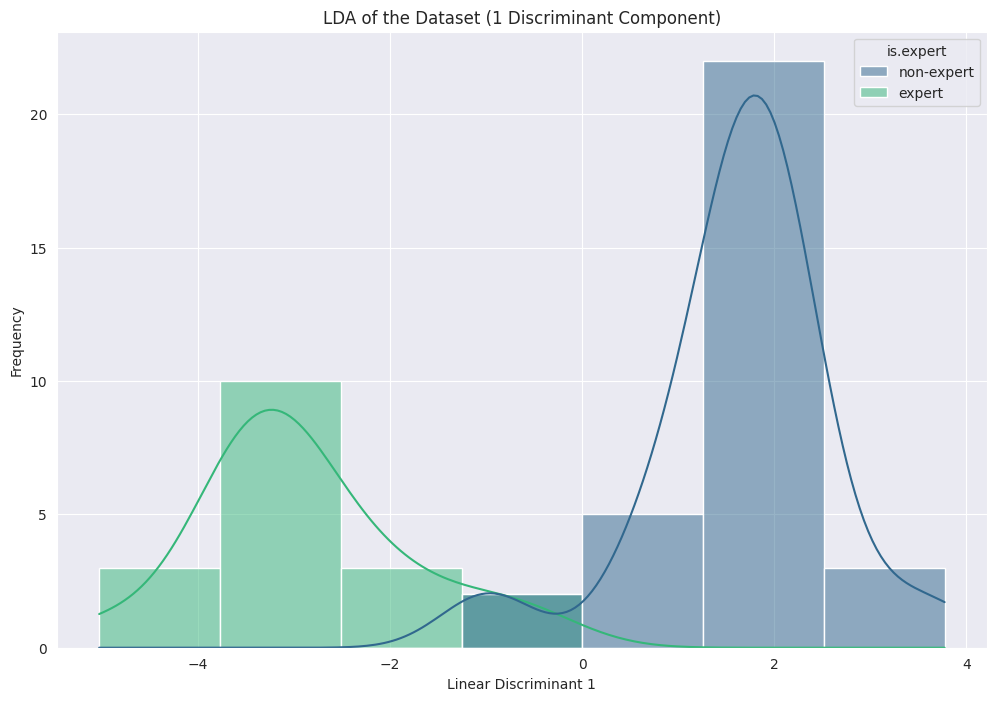


--- Finding Best Threshold for Classification (Corrected Method) ---
Optimal Threshold: -1.6746
Best Achievable Accuracy with this model: 96.00%

LDA analysis complete.


In [18]:
try:
    # Extract original filename (without extension)
    original_filename = os.path.splitext(os.path.basename(FILEPATH))[0]

    # 1. Load Data
    df_raw = load_data(FILEPATH)

    # 2. Preprocess Features
    X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

    # 3. Scale Features
    X_scaled, scaler = scale_features(X_final)

    # --- LDA ANALYSIS ---
    print("\n--- Starting LDA Analysis ---")

    # 4. Transform data using LDA and save the result
    transformed_data_path = os.path.join(OUTPUT_DIR, f'lda_transformed_data_{original_filename}.csv')
    X_lda = transform_and_save_lda(X_scaled, y_target, df_raw, ID_COLUMN, transformed_data_path)

    # 5. Visualize the LDA results
    viz_path = os.path.join(OUTPUT_DIR, f'lda_visualization_{original_filename}.png')
    visualize_lda(X_lda, y_target, viz_path)

    # 6. Test the accuracy of a simple threshold model on the new LDA feature
    # This only works for the binary classification case where LDA gives 1 component
    if X_lda.shape[1] == 1:
        find_best_threshold_and_accuracy(X_lda.flatten(), y_target)

    print("\nLDA analysis complete.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

In [21]:
# 1. Load Data
df_raw = load_data(FILEPATH)

# 2. Preprocess Features
X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

# 3. Scale Features
X_scaled, scaler = scale_features(X_final)

# This function now performs the entire LDA pipeline robustly.
evaluate_pipeline_robustly(X_final, y_target)

Loading data from 'preprocessed_all_features_for_ml_wide_2025_06_30_08_55_58.csv'...
Data loaded successfully.
Preprocessing features...
Original feature shape: (50, 848)
Removing 83 constant features...
Final feature shape after preprocessing: (50, 765)
Standardizing features...
Features standardized successfully.

--- Running Robust Cross-Validation with a Pipeline ---
Cross-validation finished after 50 folds.
Mean Accuracy: 76.00%
Standard Deviation: 42.71%


In [27]:
# 1. Load Data
df_raw = load_data(FILEPATH)

# 2. Preprocess Features
X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

# 3. Scale Features
X_scaled, scaler = scale_features(X_final)

# Evaluate the PCA-based pipeline
evaluate_pca_pipeline(X_final, y_target, n_components=23)

Loading data from 'preprocessed_all_features_for_ml_wide_2025_06_30_08_55_58.csv'...
Data loaded successfully.
Preprocessing features...
Original feature shape: (50, 848)
Removing 83 constant features...
Final feature shape after preprocessing: (50, 765)
Standardizing features...
Features standardized successfully.

--- Running Robust CV with PCA (23 components) ---
Cross-validation finished after 50 folds.
Mean Accuracy: 70.00%
Standard Deviation: 45.83%


## Last try to get linearly separable components from PCA

Configuration set and output directory is ready.
Loading data from 'agg_data/ml_features_all_20250709_214248.csv'...
Data loaded successfully.
Preprocessing features...
Original feature shape: (50, 832)
Removing 83 constant features...
Final feature shape after preprocessing: (50, 749)
Standardizing features (centering and scaling)...
Features standardized successfully.

--- Starting PCA Analysis Pipeline ---
Dataset has 50 samples and 749 features. Max possible components: 50

Step 1 & 2: Performing Exploratory PCA and Generating Scree Plot...
Scree plot saved to 'pca_files_varimax/pca_scree_plot_ml_features_all_20250709_214248.png'


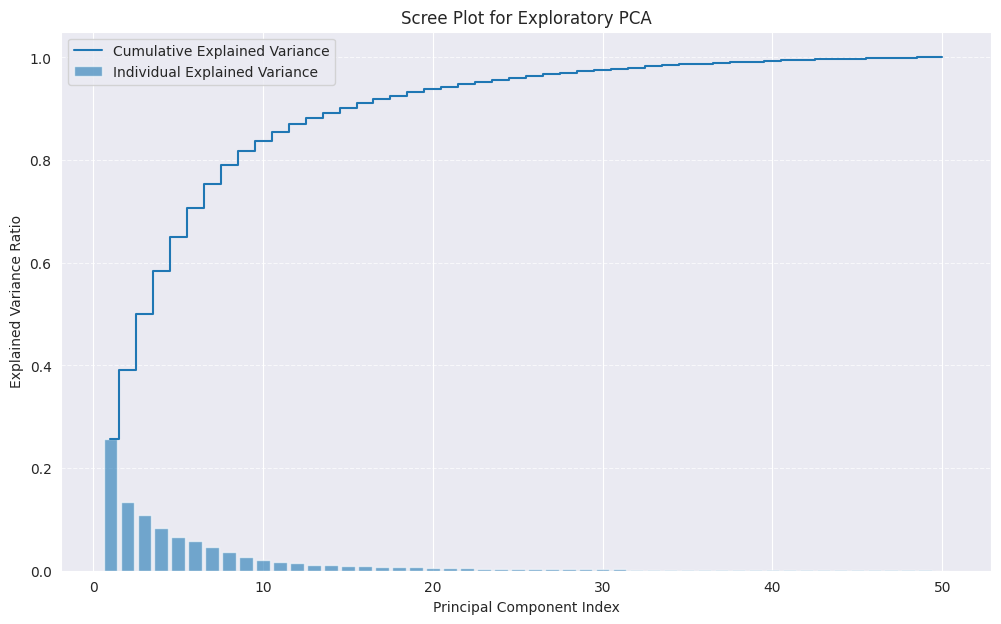


Step 3: Based on your cut-off of 23 components, the accounted variance is: 95.23%

Step 4: Performing PCA with 23 components...

Step 5: Applying Varimax rotation...

--- Generating Outputs for Rotated Data ---
2D visualization of rotated components saved to 'pca_files_varimax/pca_varimax_2d_visualization_ml_features_all_20250709_214248.png'


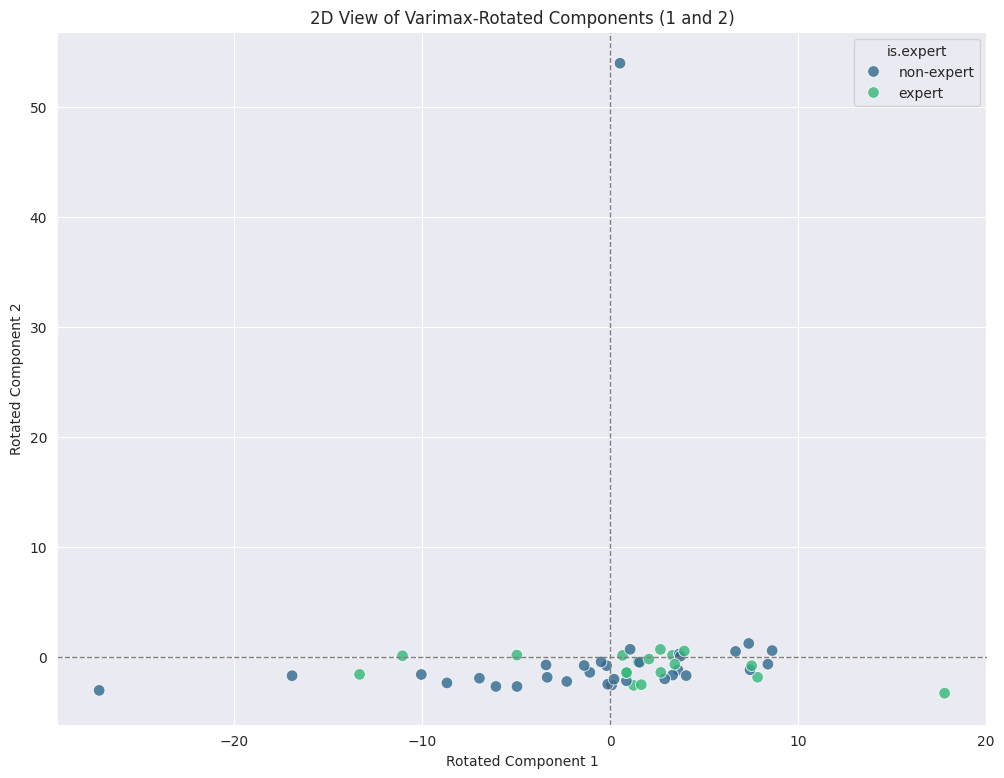

Transformed data with 23 rotated components saved to 'pca_files_varimax/pca_rotated_data_ml_features_all_20250709_214248.csv'

PCA analysis with Varimax rotation complete.


In [1]:
import os
import re
from datetime import datetime
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from factor_analyzer.rotator import Rotator
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def load_data(filepath: str, sep: str = "\t") -> DataFrame:
    """
    Loads data from a specified file path.
    """
    print(f"Loading data from '{filepath}'...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: The file '{filepath}' was not found.")
    df = pd.read_csv(filepath, sep=sep)
    print("Data loaded successfully.")
    return df


def preprocess_features(df: DataFrame, target_col: str, id_col: str) -> Tuple[DataFrame, Series]:
    """
    Prepares the data for ML by separating features and target,
    one-hot encoding categoricals, and removing constant features.
    """
    print("Preprocessing features...")
    y = df[target_col]
    X = df.drop(columns=[id_col, target_col])
    print(f"Original feature shape: {X.shape}")

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if not categorical_cols.empty:
        print(f"One-hot encoding categorical columns: {categorical_cols.tolist()}")
        X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)

    constant_features = [col for col in X.columns if X[col].nunique() == 1]
    if constant_features:
        print(f"Removing {len(constant_features)} constant features...")
        X = X.drop(columns=constant_features)

    print(f"Final feature shape after preprocessing: {X.shape}")
    return X, y


def scale_features(X_df: DataFrame) -> Tuple[np.ndarray, StandardScaler]:
    """
    Standardizes features to have a mean of 0 and a standard deviation of 1.
    """
    print("Standardizing features (centering and scaling)...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    print("Features standardized successfully.")
    return X_scaled, scaler


def perform_pca_with_varimax_rotation(
    X_scaled: np.ndarray,
    y: Series,
    df_original: DataFrame,
    id_col: str,
    output_dir: str,
    filename_suffix: str,
    n_components_to_rotate: int,
):
    """
    Performs the full PCA workflow as described in the reference paper.

    1.  Conducts an exploratory PCA.
    2.  Generates a scree plot for component selection.
    3.  Performs a second PCA with a specified number of components.
    4.  Applies Varimax rotation.
    5.  Visualizes the rotated components.
    6.  Saves the final transformed data.
    """
    print("\n--- Starting PCA Analysis Pipeline ---")
    # Get both samples and features, as the max number of components is the minimum of the two.
    n_samples, n_features = X_scaled.shape
    max_possible_components = min(n_samples, n_features)
    print(f"Dataset has {n_samples} samples and {n_features} features. Max possible components: {max_possible_components}")

    # Step 1 & 2: Exploratory PCA and Scree Plot
    print("\nStep 1 & 2: Performing Exploratory PCA and Generating Scree Plot...")

    exploratory_pca = PCA(n_components=max_possible_components)
    exploratory_pca.fit(X_scaled)

    explained_variance = exploratory_pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(12, 7))
    plt.bar(
        range(1, max_possible_components + 1),
        explained_variance,
        alpha=0.6,
        label="Individual Explained Variance",
    )
    plt.step(
        range(1, max_possible_components + 1),
        cumulative_variance,
        where="mid",
        label="Cumulative Explained Variance",
    )
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel("Principal Component Index")
    plt.title("Scree Plot for Exploratory PCA")
    plt.legend(loc="best")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    scree_plot_path = os.path.join(output_dir, f"pca_scree_plot_{filename_suffix}.png")
    plt.savefig(scree_plot_path)
    print(f"Scree plot saved to '{scree_plot_path}'")
    plt.show()

    # Step 3: Report variance for the chosen cut-off
    if n_components_to_rotate > max_possible_components:
        raise ValueError(
            f"n_components_to_rotate ({n_components_to_rotate}) cannot be greater than the max possible components ({max_possible_components})."
        )
    variance_accounted = cumulative_variance[n_components_to_rotate - 1]
    print(
        f"\nStep 3: Based on your cut-off of {n_components_to_rotate} components, "
        f"the accounted variance is: {variance_accounted:.2%}"
    )

    # Step 4: Perform another PCA with M components
    print(f"\nStep 4: Performing PCA with {n_components_to_rotate} components...")
    pca_final = PCA(n_components=n_components_to_rotate)
    pca_final.fit(X_scaled)
    loadings = pca_final.components_.T

    # Step 5: Rotate components using Varimax
    print("\nStep 5: Applying Varimax rotation...")
    rotator = Rotator(method="varimax")
    rotated_loadings = rotator.fit_transform(loadings)

    # Calculate the new scores by projecting the data onto the rotated axes
    X_rotated = np.dot(X_scaled, rotated_loadings)

    # --- Visualization and Saving ---
    print("\n--- Generating Outputs for Rotated Data ---")

    rotated_cols = [f"RC_{i+1}" for i in range(n_components_to_rotate)]
    df_rotated = pd.DataFrame(X_rotated, columns=rotated_cols)
    df_rotated[id_col] = df_original[id_col].reset_index(drop=True)
    df_rotated[y.name] = y.reset_index(drop=True)

    final_cols = [id_col, y.name] + rotated_cols
    df_rotated = df_rotated[final_cols]

    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        x="RC_1",
        y="RC_2",
        hue=y.name,
        data=df_rotated,
        palette="viridis",
        s=70,
        alpha=0.8,
    )
    plt.title(f"2D View of Varimax-Rotated Components (1 and 2)")
    plt.xlabel("Rotated Component 1")
    plt.ylabel("Rotated Component 2")
    plt.legend(title=y.name)
    plt.grid(True)
    plt.axhline(0, color="grey", lw=1, linestyle="--")
    plt.axvline(0, color="grey", lw=1, linestyle="--")
    viz_path = os.path.join(
        output_dir, f"pca_varimax_2d_visualization_{filename_suffix}.png"
    )
    plt.savefig(viz_path)
    print(f"2D visualization of rotated components saved to '{viz_path}'")
    plt.show()

    output_path = os.path.join(output_dir, f"pca_rotated_data_{filename_suffix}.csv")
    df_rotated.to_csv(output_path, sep="\t", index=False)
    print(f"Transformed data with {n_components_to_rotate} rotated components saved to '{output_path}'")


def extract_timestamp_from_filepath(filepath: str) -> str:
    """
    Extracts a timestamp from the file path if it exists.
    """
    match = re.search(r"\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}", filepath)
    return match.group(0) if match else ""


# --- Main Execution ---

# --- Configuration ---
FILEPATH = "agg_data/ml_features_all_20250709_214248.csv"
TARGET_COLUMN = "is.expert"
ID_COLUMN = "Participant_unique"
OUTPUT_DIR = "pca_files_varimax"

N_COMPONENTS_TO_ROTATE = 23

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
original_filename = os.path.splitext(os.path.basename(FILEPATH))[0]

print("Configuration set and output directory is ready.")

try:
    # 1. Load Data
    df_raw = load_data(FILEPATH)

    # 2. Preprocess Features
    X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

    # 3. Scale Features (Center and Scale)
    X_scaled, scaler = scale_features(X_final)

    # 4. Perform the complete PCA with Varimax Rotation workflow
    perform_pca_with_varimax_rotation(
        X_scaled=X_scaled,
        y=y_target,
        df_original=df_raw,
        id_col=ID_COLUMN,
        output_dir=OUTPUT_DIR,
        filename_suffix=original_filename,
        n_components_to_rotate=N_COMPONENTS_TO_ROTATE,
    )

    print("\nPCA analysis with Varimax rotation complete.")

except Exception as e:
    print(f"\nAn error occurred: {e}")

## Full Varimax PCA pipeline run

In [1]:
import os
import re
from datetime import datetime
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from factor_analyzer.rotator import Rotator
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- Helper Functions ---
def load_data(filepath: str, sep: str = "\t") -> DataFrame:
    """Loads data from a specified file path."""
    print(f"Loading data from '{filepath}'...")
    df = pd.read_csv(filepath, sep=sep)
    print("Data loaded successfully.")
    return df

def preprocess_features(df: DataFrame, target_col: str, id_col: str) -> Tuple[DataFrame, Series]:
    """Prepares the data for ML by separating features and target."""
    print("Preprocessing features...")
    y = df[target_col]
    X = df.drop(columns=[id_col, target_col])
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if not categorical_cols.empty:
        X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)
    constant_features = [col for col in X.columns if X[col].nunique() == 1]
    if constant_features:
        X = X.drop(columns=constant_features)
    print(f"Final feature shape after preprocessing: {X.shape}")
    return X, y

def scale_features(X_df: DataFrame) -> Tuple[np.ndarray, StandardScaler]:
    """Standardizes features to have a mean of 0 and a standard deviation of 1."""
    print("Standardizing features (centering and scaling)...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    return X_scaled, scaler

# --- Main PCA Function ---
def perform_pca_with_varimax_rotation(
    X_scaled: np.ndarray,
    y: Series,
    df_original: DataFrame,
    id_col: str,
    output_dir: str,
    filename_suffix: str,
    n_components_to_rotate: int,
    generate_plots: bool = True,
):
    """Performs the full PCA workflow with optional plotting."""
    print("\n--- Starting PCA Analysis Pipeline ---")
    n_samples, n_features = X_scaled.shape
    max_possible_components = min(n_samples, n_features)
    print(f"Dataset has {n_samples} samples and {n_features} features. Max components: {max_possible_components}")

    exploratory_pca = PCA(n_components=max_possible_components)
    exploratory_pca.fit(X_scaled)
    explained_variance = exploratory_pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Step 1 & 2: Exploratory PCA and Scree Plot (Optional)
    if generate_plots:
        print("\nStep 1 & 2: Generating Scree Plot...")
        plt.figure(figsize=(12, 7))
        plt.bar(range(1, max_possible_components + 1), explained_variance, alpha=0.6, label="Individual Explained Variance")
        plt.step(range(1, max_possible_components + 1), cumulative_variance, where="mid", label="Cumulative Explained Variance")
        plt.ylabel("Explained Variance Ratio")
        plt.xlabel("Principal Component Index")
        plt.title(f"Scree Plot for {filename_suffix}")
        plt.legend(loc="best")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        scree_plot_path = os.path.join(output_dir, f"pca_scree_plot_{filename_suffix}.png")
        plt.savefig(scree_plot_path)
        plt.close() # Close plot to prevent displaying in a loop
        print(f"Scree plot saved to '{scree_plot_path}'")
    else:
        print("\nStep 1 & 2: Exploratory PCA complete (plotting skipped).")

    # Step 3: Report variance
    if n_components_to_rotate > max_possible_components:
        raise ValueError(f"n_components_to_rotate ({n_components_to_rotate}) exceeds max possible ({max_possible_components}).")
    variance_accounted = cumulative_variance[n_components_to_rotate - 1]
    print(f"\nStep 3: {n_components_to_rotate} components account for {variance_accounted:.2%} of variance.")

    # Step 4 & 5: Final PCA, Rotation, and Saving
    print(f"\nStep 4 & 5: Performing PCA with {n_components_to_rotate} components and Varimax rotation...")
    pca_final = PCA(n_components=n_components_to_rotate)
    pca_final.fit(X_scaled)
    rotator = Rotator(method="varimax")
    rotated_loadings = rotator.fit_transform(pca_final.components_.T)
    X_rotated = np.dot(X_scaled, rotated_loadings)

    rotated_cols = [f"RC_{i+1}" for i in range(n_components_to_rotate)]
    df_rotated = pd.DataFrame(X_rotated, columns=rotated_cols)
    df_rotated[id_col] = df_original[id_col].reset_index(drop=True)
    df_rotated[y.name] = y.reset_index(drop=True)
    df_rotated = df_rotated[[id_col, y.name] + rotated_cols]

    output_path = os.path.join(output_dir, f"pca_rotated_data_{filename_suffix}.csv")
    df_rotated.to_csv(output_path, sep="\t", index=False)
    print(f"Transformed data saved to '{output_path}'")

    # Optional 2D Visualization
    if generate_plots:
        print("\nGenerating 2D visualization of rotated components...")
        plt.figure(figsize=(12, 9))
        sns.scatterplot(x="RC_1", y="RC_2", hue=y.name, data=df_rotated, palette="viridis", s=70, alpha=0.8)
        plt.title(f"2D View of Rotated Components for {filename_suffix}")
        plt.xlabel("Rotated Component 1")
        plt.ylabel("Rotated Component 2")
        plt.legend(title=y.name)
        plt.grid(True)
        viz_path = os.path.join(output_dir, f"pca_varimax_2d_visualization_{filename_suffix}.png")
        plt.savefig(viz_path)
        plt.close() # Close plot
        print(f"2D visualization saved to '{viz_path}'")

# --- Main Execution ---

# --- 1. Configuration ---
FILENAMES_TO_PROCESS = [
    'ml_features_all_20250709_214248.csv',
    'ml_features_all_and_medical_20250709_213116.csv',
    'ml_features_all_and_medical_and_content_20250709_214000.csv',
    'ml_features_content_20250709_214417.csv',
    'ml_features_medical_20250709_214316.csv',
    'ml_features_medical_and_content_20250709_214355.csv',
    'ml_features_non_medical_20250711_021809.csv'
]

FILEPATHS_TO_PROCESS = [os.path.join("agg_data", fname) for fname in FILENAMES_TO_PROCESS]

GENERATE_PLOTS = False # Set to False to skip generating .png files
TARGET_COLUMN = "is.expert"
ID_COLUMN = "Participant_unique"
OUTPUT_DIR = "pca_files_varimax"
N_COMPONENTS_TO_ROTATE = 23

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Configuration set and output directory is ready.")

# --- 2. Main Loop ---
for filepath in FILEPATHS_TO_PROCESS:
    print(f"\n{'='*30} PROCESSING FILE: {filepath} {'='*30}")

    try:
        if not os.path.exists(filepath):
            print(f"Warning: File not found at '{filepath}'. Skipping.")
            continue

        # Get a clean filename suffix for output files
        original_filename = os.path.splitext(os.path.basename(filepath))[0]

        # 1. Load Data
        df_raw = load_data(filepath)

        # 2. Preprocess Features
        X_final, y_target = preprocess_features(df_raw, TARGET_COLUMN, ID_COLUMN)

        # 3. Scale Features
        X_scaled, scaler = scale_features(X_final)

        # 4. Perform PCA workflow
        perform_pca_with_varimax_rotation(
            X_scaled=X_scaled,
            y=y_target,
            df_original=df_raw,
            id_col=ID_COLUMN,
            output_dir=OUTPUT_DIR,
            filename_suffix=original_filename,
            n_components_to_rotate=N_COMPONENTS_TO_ROTATE,
            generate_plots=GENERATE_PLOTS, # Pass the boolean flag
        )
        print(f"\nAnalysis complete for {filepath}.")

    except Exception as e:
        print(f"\nAn error occurred while processing {filepath}: {e}")

print(f"\n{'='*30} ALL FILES PROCESSED {'='*30}")

Configuration set and output directory is ready.

============================== PROCESSING FILE: agg_data/ml_features_all_20250709_214248.csv ==============================
Loading data from 'agg_data/ml_features_all_20250709_214248.csv'...
Data loaded successfully.
Preprocessing features...
Final feature shape after preprocessing: (50, 749)
Standardizing features (centering and scaling)...

--- Starting PCA Analysis Pipeline ---
Dataset has 50 samples and 749 features. Max components: 50

Step 1 & 2: Exploratory PCA complete (plotting skipped).

Step 3: 23 components account for 95.23% of variance.

Step 4 & 5: Performing PCA with 23 components and Varimax rotation...
Transformed data saved to 'pca_files_varimax/pca_rotated_data_ml_features_all_20250709_214248.csv'

Analysis complete for agg_data/ml_features_all_20250709_214248.csv.

============================== PROCESSING FILE: agg_data/ml_features_all_and_medical_20250709_213116.csv ==============================
Loading data fro

# Feature Analyzation for the adapted BEyeLSTM model

In [6]:
import pandas as pd
df = pd.read_csv('../lstm_hybrid/data/sorted_et_data_merged_with_ann_materials_25_06_17.csv', sep='\t')
columns = df.columns
for col in columns:
    print("'" + col + "',")

/tmp/ipykernel_114132/380380651.py:2: DtypeWarning: Columns (11,57,61,70,72,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sorted_et_data_merged_with_ann_materials_25_06_17.csv', sep='\t')


'list',
'Participant',
'Participant_unique',
'age',
'sex',
'Payment',
'is.expert',
'educational_background',
'field_of_study',
'current_situation',
'current_situation_old',
'Participant_commnts_new',
'Recording',
'situation_actuelle',
'Timeline',
'Media',
'Media_old',
'textid',
'text.type',
'text.version',
'screenid',
'Sentence_index',
'Word_index',
'AOI',
'Total_duration_of_fixations',
'Average_duration_of_fixations',
'Minimum_duration_of_fixations',
'Maximum_duration_of_fixations',
'Number_of_fixations',
'Time_to_first_fixation',
'Duration_of_first_fixation',
'Average_pupil_diameter',
'Total_duration_of_whole_fixations',
'Average_duration_of_whole_fixations',
'Minimum_duration_of_whole_fixations',
'Maximum_duration_of_whole_fixations',
'Number_of_whole_fixations',
'Time_to_first_whole_fixation',
'Duration_of_first_whole_fixation',
'Average_whole-fixation_pupil_diameter',
'Total_duration_of_Visit',
'Average_duration_of_Visit',
'Minimum_duration_of_Visit',
'Maximum_duration_of_Visit',


Loading data from '/mnt/c/Users/Consti/PycharmProjects/BasicML/data_prep/sorted_et_data_merged_with_ann_materials_25_06_17.csv'...


/tmp/ipykernel_114132/1659758835.py:30: DtypeWarning: Columns (11,57,61,70,72,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH, sep="\t")


Data loaded successfully.
Preprocessing data...
Shape of X before dropping features: (193908, 104)
Shape of X after dropping features:  (193908, 62)
Shape before dropping empty columns: (193908, 62)
Shape after dropping empty columns:  (193908, 61)
Target variable encoded. Classes: ['expert' 'non-expert']
Data ready for analysis. Shape: (193908, 43)

Calculating feature importance with Random Forest...
Top 15 most important features:
                                  feature  importance
0     Average_whole-fixation_eye_openness    0.078823
1      Selective_regression-path_duration    0.077783
2                  Average_pupil_diameter    0.063705
3   Average_whole-fixation_pupil_diameter    0.063086
4                   word_frequency_screen    0.050504
5                     word_frequency_text    0.048877
6          Peak_velocity_of_entry_saccade    0.035742
7           Peak_velocity_of_exit_saccade    0.033808
8                 Total_duration_of_Visit    0.033197
9                    T

/tmp/ipykernel_114132/1659758835.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(25), palette='viridis')



Feature importance plot saved as 'aligned_feature_importance.png'

Analyzing correlations and selecting final features...

FINAL RECOMMENDED FEATURES FOR THE NEURAL NETWORK
(Based on the preprocessing and a correlation threshold of < 0.8)
1. Average_whole-fixation_eye_openness
2. Selective_regression-path_duration
3. Average_pupil_diameter
4. word_frequency_screen
5. Peak_velocity_of_entry_saccade
6. Peak_velocity_of_exit_saccade
7. Total_duration_of_Visit
8. Time_to_exit_saccade
9. word_count_text
10. AOI_length
11. Duration_of_first_Visit
12. Regression-path_duration
13. tag.id
14. First-pass_first_fixation_duration
15. Maximum_duration_of_fixations
16. Duration_of_first_whole_fixation
17. Minimum_duration_of_fixations
18. First-pass_duration
19. tag.type
20. right_dependents
21. left_dependents
22. First-pass_regression


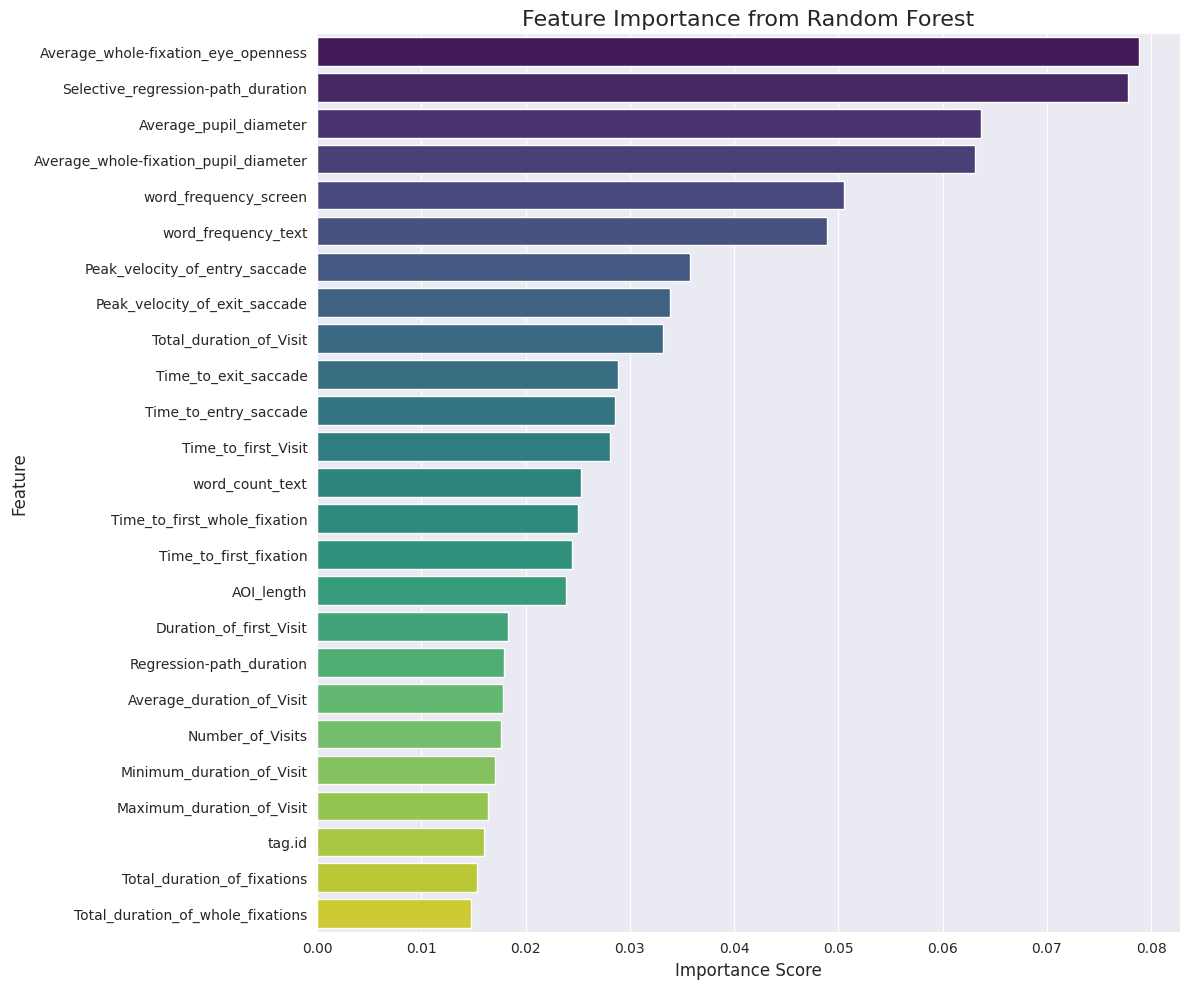

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from pathlib import Path

# --- 1. Configuration & Loading ---
# Assumes the script is run from the same directory as your notebook
# Adjust if necessary
try:
    cwd = Path().resolve() # /project/notebooks
    project_root = cwd.parent # /project
    data_path = project_root / 'data_prep'
    FILE_PATH = data_path / 'sorted_et_data_merged_with_ann_materials_25_06_17.csv'
except IndexError:
    # Fallback if the script is not in a subfolder
    FILE_PATH = '../lstm_hybrid/data/sorted_et_data_merged_with_ann_materials_25_06_17.csv'


TARGET_COLUMN = 'is.expert'
ID_COLUMN = 'Participant_unique'
# Set a correlation threshold for removing redundant features.
CORRELATION_THRESHOLD = 0.8

print(f"Loading data from '{FILE_PATH}'...")
try:
    df = pd.read_csv(FILE_PATH, sep="\t")
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file '{FILE_PATH}' was not found.")
    print("Please check the path and ensure the script's location is correct.")
    exit()

# --- 2. Preprocessing & Cleaning (Aligned with your script) ---
print("Preprocessing data...")

# Define features and target
features_list = df.columns.difference([TARGET_COLUMN, ID_COLUMN]).tolist()
X = df[features_list].copy()
y = df[TARGET_COLUMN].copy()

# Drop rows where the target variable is missing
y.dropna(inplace=True)
X = X.loc[y.index]

features_to_exclude = [
    'list',
    'Participant',
    'Participant_unique',
    'age',
    'sex',
    'Payment',
    'is.expert',
    'educational_background',
    'field_of_study',
    'current_situation',
    'current_situation_old',
    'Participant_commnts_new',
    'Recording',
    'situation_actuelle',
    'Timeline',
    'Media',
    'Media_old',
    'textid',
    # 'text.type',
    # 'text.version',
    'screenid',
    'Sentence_index',
    'Word_index',
    'filename.et',
    'set1',
    'set2',
    'id.global.aoi.participant',
    'id.global.aoi',
    'text_version',
    'word_id_screen',
    'word_id_text',
    'is.in.bracket',
    'id.phrase.in.brackets',
    'AOI.that.in.fact.should.be',
    'id.ann',
    'id.ann.global',
    'Sentence_id_current',
    'Sentence_id_match',
    'id.piece',
    'filename.ann',
    'id.line',
    'total_word_count_screen',
    'total_word_count_text',
    'total_lemma_count_screen',
    'total_lemma_count_text',
    'index'
]

# Drop these columns from the DataFrame X
print(f"Shape of X before dropping features: {X.shape}")
X = X.drop(columns=features_to_exclude, axis=1, errors='ignore')
print(f"Shape of X after dropping features:  {X.shape}")

print(f"Shape before dropping empty columns: {X.shape}")
X.dropna(axis=1, how='all', inplace=True)
print(f"Shape after dropping empty columns:  {X.shape}")

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target variable encoded. Classes: {le.classes_}")

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Preprocess numeric features (impute and scale)
numeric_pipeline = pd.DataFrame(X[numeric_features])
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

numeric_pipeline_imputed = imputer.fit_transform(numeric_pipeline)
numeric_pipeline_scaled = scaler.fit_transform(numeric_pipeline_imputed)
X_processed_numeric = pd.DataFrame(numeric_pipeline_scaled, columns=numeric_features, index=X.index)

# For this analysis, we will focus only on the numeric features,
# as they are most suitable for correlation matrix analysis.
# If categorical features were important, they would be one-hot encoded first.
X_final = X_processed_numeric

print(f"Data ready for analysis. Shape: {X_final.shape}")

# --- 3. Feature Importance Calculation ---
print("\nCalculating feature importance with Random Forest...")
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=7, n_jobs=-1)
model.fit(X_final, y_encoded)

# Create a DataFrame for feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_final.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

print("Top 15 most important features:")
print(feature_importance_df.head(15))

# Plot and save feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(25), palette='viridis')
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('aligned_feature_importance.png')
print("\nFeature importance plot saved as 'aligned_feature_importance.png'")

# --- 4. Correlation Analysis & Final Selection ---
print("\nAnalyzing correlations and selecting final features...")
corr_matrix = X_final.corr()

# Select final features by removing highly correlated ones
final_features = []
# Iterate through features sorted by importance
for feature in feature_importance_df['feature']:
    if not final_features:
        final_features.append(feature)
        continue

    # Check correlation with already selected features
    is_correlated = False
    for final_feature in final_features:
        correlation = corr_matrix.loc[feature, final_feature]
        if abs(correlation) > CORRELATION_THRESHOLD:
            is_correlated = True
            break # No need to check other correlations

    if not is_correlated:
        final_features.append(feature)

# --- 5. Final Output ---
print("\n" + "="*50)
print("FINAL RECOMMENDED FEATURES FOR THE NEURAL NETWORK")
print(f"(Based on the preprocessing and a correlation threshold of < {CORRELATION_THRESHOLD})")
print("="*50)
for i, feature in enumerate(final_features):
    print(f"{i+1}. {feature}")